In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import chisquare, norm, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Normal Dispersal Kernel Test

In [3]:
def test_normal_dispersal_kernel(
    algorithm, speciation=0.001, seeds=[42], sample=1.0, radius=0, sigma=100.0,
):
    total_pvalues_x = []
    total_pvalues_y = []
    total_location_deltas = []
    
    sigma_3 = int(3*sigma)
    step = int(max(sigma_3*2 / 100, 1))
    
    cdf = norm(loc=0.0, scale=sigma).cdf
    
    expected_freq = np.array([cdf(np.round(x) + step - 0.5) - cdf(np.round(x) - 0.5) for x in range(-sigma_3, sigma_3+1, step)])
    
    for seed in seeds:
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: AlmostInfinite(
                radius: {radius},
                sigma: {sigma},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalCoverage(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample,
            radius=radius, sigma=sigma,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        locations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the dispersal locations
        location_deltas = []
        with locations_io:
            reader = csv.reader(locations_io)
            next(reader)

            for row in reader:
                location_deltas.append((int(row[3]) - int(row[0]), int(row[4]) - int(row[1])))
        location_deltas = np.array(location_deltas)

        hist_x = np.histogram(location_deltas[:,0], bins=[x - 0.5 for x in range(-sigma_3, sigma_3+1+step, step)])[0]
        hist_y = np.histogram(location_deltas[:,1], bins=[x - 0.5 for x in range(-sigma_3, sigma_3+1+step, step)])[0]
        
        # Calculate the goodness of fit of the dispersal kernel
        gof_x = chisquare(hist_x, expected_freq * len(location_deltas))
        gof_y = chisquare(hist_y, expected_freq * len(location_deltas))
        
        total_pvalues_x.append(gof_x.pvalue)
        total_pvalues_y.append(gof_y.pvalue)
        total_location_deltas.append(location_deltas)
    
    gof_x_statistic, gof_x_pvalue = combine_pvalues(total_pvalues_x)
    gof_y_statistic, gof_y_pvalue = combine_pvalues(total_pvalues_y)
    
    if gof_x_pvalue <= 0.01 or gof_x_pvalue >= 0.99 or gof_y_pvalue <= 0.01 or gof_y_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_x_pvalue <= 0.05 or gof_x_pvalue >= 0.95 or gof_y_pvalue <= 0.05 or gof_y_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_x_pvalue <= 0.1 or gof_x_pvalue >= 0.9 or gof_y_pvalue <= 0.1 or gof_y_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
        
    display(Markdown("#### Fisher’s combined Chi-squared test:"))
    display(Markdown(f"* x-axis p-value: {gof_x_pvalue}\n* x-axis statistic: {gof_x_statistic}"))
    display(Markdown(f"* y-axis p-value: {gof_y_pvalue}\n* y-axis statistic: {gof_y_statistic}"))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("Distribution of x-axis p-values")
    ax1.set_xlabel("p")
    ax1.set_ylabel("pdf")
    ax1.hist(total_pvalues_x, density=True)
    ax2.set_title("Distribution of y-axis p-values")
    ax2.set_xlabel("p")
    ax2.set_ylabel("pdf")
    ax2.hist(total_pvalues_y, density=True)
    plt.show()
    
    display(Markdown("#### Dispersal Histograms:"))
    
    location_deltas = np.concatenate(total_location_deltas)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    ax1.set_title("Per-generation relative dispersal")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    hist1 = ax1.hist2d(location_deltas[:,0], location_deltas[:,1], bins=(range(-sigma_3, sigma_3+1, step), range(-sigma_3, sigma_3+1, step)), density=True)
    fig.colorbar(hist1[3], ax=ax1)
    
    x = np.linspace(-sigma_3, sigma_3, 2*sigma_3 + 1)
    p = norm.pdf(x, loc=0.0, scale=sigma)
    
    ax2.set_title("Dispersal histogram x")
    ax2.set_xlabel("x")
    ax2.set_ylabel("pmf")
    ax2.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,0])
    ax2.hist(location_deltas[:,0], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax2.legend()
    ax2.legend(loc='lower center')
    
    ax3.set_title("Dispersal histogram y")
    ax3.set_xlabel("y")
    ax3.set_ylabel("pmf")
    ax3.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,1])
    ax3.hist(location_deltas[:,1], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax3.legend(loc='lower center')
    
    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:orange'>*Classical*</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.5744013436141189
* x-axis statistic: 1987.4948338751033

* y-axis p-value: 0.0825372728089108
* y-axis statistic: 2088.4034936775724

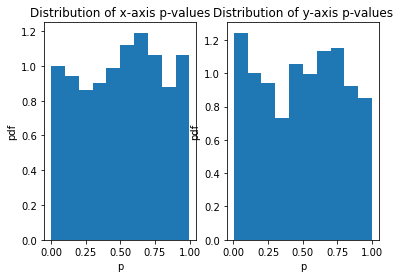

#### Dispersal Histograms:

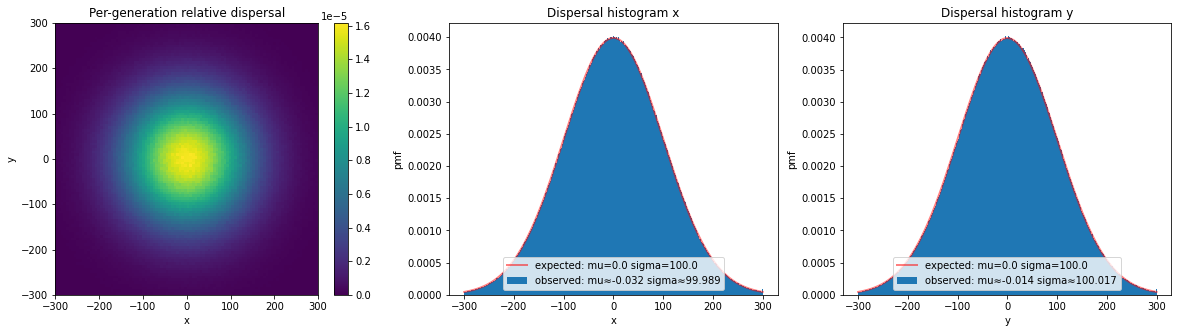

#### Parameters:
* seeds: [12347632420053478878 17619410664006903108 14633543501907672029
 14336512758858628367 16857973305261171903 16907422023925739217
  2121578651964846256 16523737754224577901  3535127898090241597
 11731815620099784891 12559769240345728624  3229557835261891429
  3774465270440911412  4676514688937715717  8294082634427879744
  7406653519122161576 12210902206227415472 16549806513258603052
  7618705948242837532   140628733711001077 13619744478201974020
 14938252728038984282  3823146897409420810 11300233464993063545
  6529264730484845849  4740690284591093309  5992173668830476277
 11105200828855130456  8909762564141814361 16544307304313297330
   904490516690017528  4394860758468864910  4431475185450121782
 18024639533207059690  5496815061117555167 11891471283898569415
  2442368131010680519 17417880604259482430  2635544339341977642
 16708601179213640708  6538792394142297868  9865543230325544039
 13335707905441021826 13064538950164386463  2599476398772327103
  5306493973096795344  9451722113478977509 15728558380172415933
 16860498469239242092 15594212294886096574  5527982767221177565
 13079281594899587588 10350762585220093953  5215190758031937261
  2262046512216858459 16581274866618778201 15141601140532057156
 15235383375040381510   433190764052363480  2408174829697660930
 14827199737506734789 14017829123145159063 14657361471778150246
 15150601227469584138 10559289723767635607  1888052655810789851
  2014838954706342565 16388222905789950479  8554479365033496554
 11244031855058487370  7545782431421138643 15591703275583939234
 17531228788141130979  2020007790737582151  9423676463267199633
  5432926800255837279  6269287962871789136  2535802645140345121
  7385605538038911551 16426617111536802532 13705246388535478094
  4077155166117621370 15816599843964811870 12611367229021052224
  5518345460321831547 15215548433188003645  2006882069189416405
  4746418687160111773 17835076902663940444 17079875564275340654
  6346119852534915713 14322828720980011645 15835232323975388258
  9105043728120665646  4046400821509412236  7769270760100212530
  5493082839362839583  2195411601282364630 16794526187652174340
 11779394695889905430   525281763318799964  9532979924371405155
 13658829771754414686 15722863508468719268  5171467212500327045
 11235798002838352012    62031721356488744  6342455606866668720
  6208531473755094102   879326263907787307 15311291359347429711
 11454629716994964268  3110498457365751325  5473057796843523865
 12589256233275898014 10799417286492494194 17646573756671916245
  9717605107395100037    68084704625545680 18288655625520247461
 17280331874705436921 14176045430668952431 13141496333732454881
 13874223531077797122  8955217530024368967  4920265833504051788
  7789102035440392942  9900445987468894838  2917944273006828796
  5990076783235853436  6849611705652773349  9462908060058053939
 13507704390048762307 16514508200406972810 15864256859072240144
  1081708006701504196 16134666704857160829  9064479065654657176
 17393039214866358592    76534969847553803  6534573827133575711
  8087856327319580981 13489899905674094981  6359158934826177305
  7319509847749938445 16020218878886791880 10123913056359272533
 18216281112568225843  9557407961921110766 16439715624956472703
  9152426607376025090 16903517095497455423  5201732392458218233
  1593844220242559533  5461500244188250238 13016952831653096990
 12412308526441602829  5121830355742113763  7108421497302439572
  5134656309077307593 12048200675130198408 14476021226659817766
 12141111696728099012  3895766306365571343  7907292479681433419
  7771349556593880163  4660808788422520795  5867873239394544725
 10095332536643897995  6863716750012966347  9078165851355230135
  2570042090076254909 14440484376652031437  5550274282733647799
 11824480072509598109  8318634072032697874 16097423998209958303
  8983059396264991904   749930123074290053  7126606571126720364
 13934222512909179472  8421981680622692257  1128936966178181373
 15401393620418554504  9114825942148660550   611774675115752443
  4633526784618784480 13439921844262400262 17666310619752711324
  7720623143174495369 12722638591276093573 17436099795759220197
 11640391707470564219  5296580320460472084  8372030534512913651
 17961723363506545246 15839273538590588269  8121719452847459805
  1922022457774842141 12990260030825212410 13986237199268866002
  1423769503489528454  5886859087323229110  2076901915169202025
 12247855273982153249 10401084972110206555  8048459008350821980
 15080617977986494580 16553005448610520915 18381997421125194901
 17240938671716229368 16625578927059738120 14060303630496511473
 12201829849111447920 12157563893697572118 12299857730796435517
  8763365115351492234 13355352181892951266 18065203890558457795
 16066517719234352383  1266590032625384735  5346680873732956509
 13046661465511505645  6208535258697859051   532261369593886045
  1289641358742184844 13531172420615476753 13240966499406613845
  1363180971888010736  3216103433347671584  2813477604441226710
 13468454352486056665 11438995324555834160 18345932177822138774
 11473191549290600584  5572957450693997277 16304550613295822770
   807695116168759329 13844722371743640796 17075766568347256389
 17583153775766096738 17821397393805453285  3736424531756778532
 18029825616208040444 17831837509319748615 14412802315965379234
 11553023647493932182 10898476418451259815  8453441729486156305
  3155671815358812204 15714133793448062856 11269909874649419595
 10159701857090903174 10751759715058874229  1384268550492358166
  5508676079420233342  6469277570164906227  4582129499939964187
  8982735884102446859 18404616241600160639  5244363109534101481
  4289936068241907812  4339015280748036498  4722846007860569955
 15007610774627532585   732314378631911995  1890231132399758709
 14611789162292550626  8073570226363270296 17333683189302151476
  6836688294669294483 17123840677318538432 13778717072232055309
   799426956426219842  3294060049254213904  3511974038563779066
  9320191240381269305 14943608473613293067  7260018060841958939
  4095820441212614785 11146433179653854174 12342297253975816669
 14629108545572372120  7282907330643967035  6843973367530565772
  8242027073789737533  2298606481743977544  5816752351387417877
  9334575572440226973  8741327269553501370  8411068560742959305
 17273531778683202590  1502083229534967585 13461488835307238798
  9903670865873923788  2424655636049470421 12923952807127144902
 17193622876689271020  4125644732591217275 18347377105143116540
  5194772835655427577  8192762143972176459 16868570868749376951
  4149365649935703704  5883016918917119264  1958725124421893493
 10369597534120141243  3274522076556585756  4405713111756732699
  5193884442431119274 15876298195375339050  9256035826839806993
 18053187261168252500 11156236534516516333 11466228733617930470
 16132128247456984874 14304544058789012683  7682908031478057888
 15959826950155998680  5064069521428675517 13396479486928364284
 11524724096231964599  1056930389583667805 12375121150391835008
 14113298635244726802 12687394142133379286 16279727061318044047
  6462036785782884954 11854473666262562040 14090100992229042537
  2627323243002082877  9157436942692781066  7743058163357119871
 12821538434590999025 13732173532472260360  2076258552937505304
  4775476094875474717  6861566732958026212 16135473756255287278
  4145270396179241735 13457875868540872938 14257070417887975202
 11409067758081438021  8863715129163751438  6378975160511646825
 18092970812103747241 12962299481812037987 14159890327560485598
  5539952806416511500  8426002836913053696 11646673606654995814
  7349647310755977015 15776631290226764773  5969485872570468574
 15360762153711593610 11747854368005718373 17750810009080815704
 16113866595022649413 12161406613327240836 17105221431467910185
  4115164031070406957  5712081446397161238  4766129703459989858
  1207975107046719051  8131495329217393808 11680684859359803298
  7772821730729357259  7263753195962575100  6617965670351816765
  8475734495356754391 13090583215920002801  1137035202449207272
 15535261717366487552  3870001976455390532 17638921230118127444
 16061987055975829997 10203912323542125258 18078238889558422789
  8251418293977250362 10937345076829767461  3244545160452494798
 11621935713247475380  4903407579794942720 13450606258562454873
  5442262974603470951  2016428891563468358 16513919385077739408
  1593875659068936070 15942612026895889265 12067079687109377100
  4304256102922282614  8610118301025636378  5335171910385832093
 16303386237400477135 13332740120943926917 12949811286152165315
  8286091215452313078  2961119477237236929  2881562060038022527
 16414356717528354606  2281909790689455412  8530124819855129874
 15561493004850664073 13322770223444803658  3518431356629670062
  8075530624845905893 17958384802509363157  1019372599953887779
 17776252658040357898 10312275746602887724 12734650343614638621
  5296649586665424881   809498954847001939   199589240196063989
  3751783816272044826  5461204212085146284 17825998202053030060
 16855045283475549740   612625063345124477 15621835591464838770
  5844931112478892049  1690276703867384474 11318699387826405002
 16535632794999178438 12189749350535483789 14974478023414450908
 11202858794169453168 10374555994104760503  5111701265936973536
 13093595315925740407  7921340167782471207  7378152614605891272
 15922945148998853940  5807927009724273800  8461284801059642596
  9776495410963150883  8728164977558786418  3815698057930761771
  9109362788813486572 12355440990671301003 17602180010034521687
  6172081626145766458  8606101516425392114 10565883339893365896
 12532704421968954560  1391015712538801217  5413432727825823398
  6121943681811911148 11258773061024812595  6052439352355170214
  3445210891146881005   457161048979925253  8464510181864576384
 16178056010183161329 13190200952850944957 17119929193402406937
  5668220732782748008  7191392716115552143  5849556041866258772
  3198393821292328926  9211083316901926698  5214906856036249683
 12015776060069524500 16568097855972476632 16895076162046889773
  8794777113128864226  1155706778740114024  5256747956458990652
  3088509327570377722  7681762184581818870  9271044740900347609
 16460416824474107016  1126468685938471806  9547625354017231918
  9296505945375398190 13786056639738089807 16625630332994279972
  2310394371226647546  9471519919800179325   310451426652749065
 12048056591353330568  3919423535748368911 12435295141342932834
  1179058097242079890  6140313569381065726 15335563271126576232
 16823746118695629515  8927953783734673788  6533921131246384940
  2221414558426060562 17246719956854916634 16208294310587291737
 10893944842969298923  5080810538696829707  1115749365228311376
  4408733422503556644  1527618225892094401  1887338007138083099
  5695478969388844369 18060535057140587299 15592453924118945295
  3179289286156705123   701923229802996624  2704819243386120609
  4100854850425542402 11958831795727894382  3692225932582248072
 10275086783482371940 17966202268137027099 12080569360555096740
  3580374119053130402  9296039139627694761  2880602310444014039
  7524495709901660090  4956811588678799325  1816789004374748451
  7893773647116215015 14929565699557408689 18265207280308959875
  4261494661804738690  7819036734736843935 18381131709772488011
  6301197616775788051 10701763941659772158  5094680593291210486
  4047151911302904946  5406142037525749068 18092855404826994018
  4242067488610567202  2034806383975203410  6625037777412597014
  4363134668536965703 16208273467056326115 17630494736702848599
  8943876220771146322 14423921478239373416 13768876375824216685
 15740920714235006836 17672833383106028533 12835695618323732764
  9306754742326453521  8976343358581394708 11072535549401135410
 12723590646019127435  4128613317868313773 11218927563035537149
 12377260263701459695 10383387549228779237  3953197943475937497
  3129099067519464115 13184986682929597388  9646714305551319871
  5696338528020016168   960202019700633033  4099539499011855643
 13656985750973758791  7168359336855311689   733483766152941979
  3813703566247322978 16391107457163176239  6902535094529018555
  7823444987682929248  8131730586024137941  2300941915514053473
 16358034343981264491  5118349631339744063  4948570573513905411
 10821688667703736218  9819102400338978147  8980629319932225750
  9604422726372915190 14981418106661555729 10118031109723870416
    39991035334281773 10171769860971309306 14857601093210650612
  7173945281908015691  4068037277775274487  4345046720705033549
 15583562307510598338  6332113550279185712  3618964212863921399
  6832437450439375701   788796329118600846  9440310566098239807
 14731299022006400695 13473412668706964399  7408590804806653485
  8009375502541618681  2284411504474626038 12169692601049838984
 15573008243984105568 16300783585832344935   741309072597246894
  8660973712488093796 16373803275176138354 16007418333894451273
 11750813569773702112  3208014554065599694 18016675849573837524
  9877357223199325184   411420818777664419   467004198185665920
   429833511294659566 11439096749394299120 15109069418005097429
 11623450024995402101 11287938360460481507  4227061996110247928
 16494090777254258130  2081858307792184446  4329289155490587744
  6213282623581833633 10097353518785399788 12997347544264425148
  5610075564752829689  7140377151619015145  8987825514490131743
  6977133241028674755 12432130982420479744  6543610842297105545
 14458463356725304757 12610308688858869221 12608847432737035763
  1671296428145469055   723166351578600802  1977159291384615125
  8796461726268918378  6350882374155839170  4135357004166301820
  4140639208058482561  4445875132760490473 11272676616634579128
 13484322192921405683 11791423390892542795   708182957097227172
 10551191499059203762  3684811867481640009    84727213727380691
 16845285547970315863  9300946070544735229   772652181475121455
   858282422124717456  6674774809982820442 10187187937274489649
 16613628887403110795 10010417748575097571  1511507698136596473
  3008505023172247821  7209911051261286963 12197782251334204351
  6365109685976669238   892739433677421646  8621219359346467995
 14739928956754409713  5301455557450659273  6364052801175596915
 12502842988850820917 10798060465765654597  6512731698737055353
  3328820856118040686 11323666603015910730 14854827551911332242
 18359448844883097579  4498844470505482817 11656154952491122678
   150058114775013761  5899490915712792880  6271046644114787527
  1134701869711347175 17057805853214410509 15706224097471465869
  5301310874828453375 16873678465464958960  4411758300780386226
 17405637023099738876  3950293429148873291 12432152677385759499
 17793358207032541589  9028807568119749628 16486675482687464848
  9766354366495881051  7453917720015887813 17963876337629757116
  4211631603340712639  1201481742277567227 16865037140611721023
 13301708794893030777 17807830710468259559 18264292367485115178
 10768762825086939617  8076574934228948657  7570316679327406008
 15275609206790868431  5010982712758393449  1128593431591756337
 12229256036071905786  2820827472727459622  6457793457925430619
  6016654920027487164  7398823801292376549  3601132938745943255
 16167480858264728300  8171021985333944228 14080612312898179283
 11513307319136133920 11543702506515993418  3872738321196828254
 11276656152330924856  7242564132266793158  7102653750405080247
 15492880694358521576  5663151047298012274 10155838480835892889
 10941813306976990408 16246811620709839941  2974887088282196462
 14937388007210626359  9992039705749420469  8080856302913983863
   701233103497016858 18333601938983713577  1360537698355474939
  3710962771869471288  9086326494082777277 14161205751762761262
 15647571494436471112  5160922401068994480 12053697738733804976
 16912874620188672126  2014168594438736592 14908831030348492767
  3252320743084354268  7497394762095546582  6493363219670852783
  5486528071217681828 16805045419367874362 10104518809325933254
  4777269177689692855 17922239818389148963 13493394624950266994
 11684510323433557887 18396049179379318766  5795866348108637078
  6646558812165772748  2834186399707353075 17735090946459436916
 15994181093196207933   846347428249540619  5427716299973339562
  8405806404383753985    11629395633368929  9980604369505775546
  6282548526130800211 12273767788347924305  5387166293596904463
 17063629515513336677   100934074881272177  8112263510606111406
 13847653136316567893 13801996527817382930 11378382952781229399
 14328198808602362651 17181761940332871745 14667056818707403832
  1885129645057164612  2740766487737130762 17608991765933179175
  4392618830585753040 15103881225521689627 13116458779876311466
  5842963739317669584  9026898994446833125  6944855709794281358
 13428376939097256852  5131086154211818877 16607916133473770330
  6004452085961089050  9152748871000270434 12991928026430607874
 11577322257230565955  6937583424850511184 11824662276981385501
 17465636662658305602 10904821919372425784 13149772653202321928
 10881122079235813717  8133973181660532318  3343271684756496156
  3201433561885112951 14584638068698231226  5601608684303433121
  5709759409393705533   586685527672169565  6070109698581662472
   215954482422579934 15748259090901165672  5254655603013063823
   263248708265683636 11253882699134594837 14774055657279413709
  2673958773689818959  1884356276824236948 15987572472422008484
  6558896165558403674  6686658965608039067 11795158891516621088
  1811919295223201853  5113244770636762868 17522446019339359052
 13897391292591132960  1600756528704875532 15990884254146994572
 15201062018402127366 13883114858667965382  9969574670000631298
 13510011501932127873  7997492314054941379  7329723995162473856
  6232203661519835248 14425335316847650472 15135436420005494705
 15054213338732567511  9855100533824171772  6795137669451625459
  4654248813249595410  3941017095707889727   921086028202364470
  3895872102378650677 15070990273031272048  9392027712327415791
 17750668268530580550 10671510736968774237  1214743410558724928
 11736706253077203565 16230605741745064946  7812698059464155859
  2859003965219560635  9839995997328182912  3819402075312992172
 12035369936271499548  9148066314476056319  2315492040625876710
  8572611530672395241 10985572946719675936   980248906978586063
  2593712523309091606 13209708105050282516 14392630134931244172
 17744818314019042364  5757961024999595436 17641349689784507117
  6807844833937400565 13550696286199682554 10551943260592150312
  4030868733302647207  4129949889935147880   281743300337386229
 13865333479165279641  2227642574088412178  4771892687756697829
 10312361877661807968  7593323426238829310 13829492794507718636
 10506939401658215093  9564083831471951025  9226711888344981776
 10567213813301160333 17947991911343349774  7053577382285307107
  1063023233744783705    99194165412508538  1472707893295295778
 13166152751579592685  8483234778312540251 13939215217877436832
  2076446352241265911  6774019018859412077  7135980124859258932
  4575922099897720654  5842720318909105338 18435881162206321149
 17222087230071957012 13636253204375207058  1154430621443495019
 14296599325926032484  4645167071900578989  5129102954808723310
 18207213992444430607   696940910824333783  4568917415140758984
  5539297121653027116  7613160882096441875  7079066322414805785
 12727891786291493946 17832133640688045511  3523105588693631858
 12350331305120733168  6531430930870089384  8922872641950496038
  7239320495419754869 13958244842098390106  2929381805875717591
 12494295163550116967  3445809128683288358 16130669821559549495
 17002277123954354533  6393056017238726182 10536019446365113594
 16099463383816529067  1285603587717468286 11389846862542188473
  1090438739622444651 12363331075008406376   305375963157599741
 15322944735682204027 11009236002364636396  7504997480712092798
  6643464855605542746  3069744635776676971  3588282934542152130
 15979388374071768457  7673071166292377815   890243640843664157
  4280427037342657125 10045151050828245204 16111745337612242720
  2706610313862695805  1019420550489868522 13315010210084335374
  9545571526611889302 12280042240092734670  7748052869478469778
 15553182790023968593 13378046807737762081  8436284243855250955
 11629210956081024744  9037230672308507007  8834895573886361445
  9849445301615550135  5198691085845384981  3805652738458307333
 16147328761101644977  7055335300783565600   576730138796190848
  5178746028811973780  3763078827411271621  2259732632609704378
  4159569808263734431 12795047734119302501  7337284092144169677
  3361413440063338091 14471372366837393098  9757489818817203304
  9840460804784062850 16978621072604753796  5667272519818257748
 12697320651092396664 13371057309989065170 10574185536860007573
  3691277027922164825  4624610617633688660  3705392674314413660
 14686000340844516426 17746210101394267386  4695083130116585285
 17116929707264530473  6229297702420690680  6712850836775094900
  3079007944353057080  1013382811944348177  3576895668098885015
 11954231350193794603  5518257172852042466  7005151869194465260
  2925133927895946184 13706784598462555001  9807041224495384428
 11136303312002659297   690791708708723903  4297534321042245309
  9319165003665074749  7452748280548687723 14517247023794326232
   301256261826873339  2312573142297389236  2257046459496521816
 12337457122895143329 17529455968238605820 16001433120698102343
  3128539249469357381  5216047500145700768  3268618184342601719
 15118747487839658929  6276538371172648176  4831141263280263915
  7334501784427861153  3905019985867594850 15464653381046147889
  8338491593165030706]

#### Configuration:
```rust
(speciation:0.01,seed:8338491593165030706,sample:0.1,algorithm:Classical(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.80930018817577
* x-axis statistic: 1944.4936124397689

* y-axis p-value: 0.41090495528968785
* y-axis statistic: 2013.6084563851578

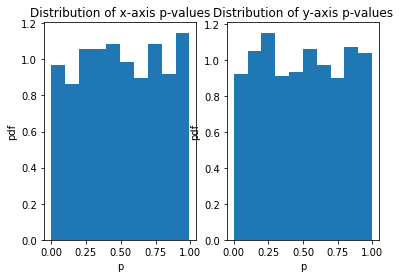

#### Dispersal Histograms:

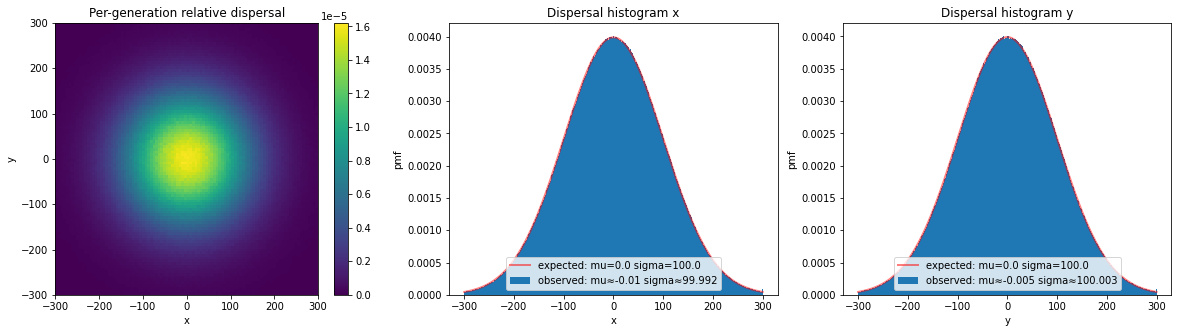

#### Parameters:
* seeds: [11440083005066394294  1940242209449349604 12478967974516549653
 13707704776740335498  6879400684179303422 12985278873473541128
  7533951184667931052 17721414624866487062 12718273018931558095
 17083403714815070688  8633296014089456728   670951065284285654
  3903747616542754814 17144958364096409814 17007369407754551394
  8935830755485461309  7037447746016940037  5213684112159171555
  9381899932497129714 16491771966851301172 13952890721074607912
 10404986292659956226  8805181341748714908  8276433613032878812
  5691640581762028568  8059620889005149624 12230224254606846614
 11074942327619619804  8932894533056979292  6098994736706526902
   827344430636068788  9156956646978706485  3520449308714936158
  8977312207278153649  7793597637472339141 10681482302287025589
   981667408157971937  2858811333324708806 12762620598018623807
   671557802795312550  1524310899856373417 12063595288610660496
 18167135269962090387 17289989543542891192 13944449598903903913
  4467989702321862701 14949503352780666487 17849450072285233335
  9775095228369461788 14797906395095173913  8866124423360029640
  7203763325038937719  8752620292844572117  1713581446429312761
 12129447189198185382  4522199762826418907 17342529259571366255
 10348158248264388671 15524416151054433498  7360574729013467797
  7154214949724082808 14531367223026125238 10585005201947146943
   671160774651568786 13787534515656814719  4124201928306065672
   791603502574108649  4922810213642725479  6896708564478908335
  4293203804450742609 17730746265410072209  7861940953062329119
 15572260557402721302  7904613258146323624 17915829173973550263
 16153862413138596595    44821736833492674  6447010665805649189
 13965210221389148930 11327074351665680972 17958682594180753247
 10887589656345462209  8155863738395443214  5881371808724150072
  6878328994183857110  7714319147841360114 17721207711088985256
  4260175878062589371 10187447241251653202 12214105082730466830
 14339264113873072430 12973903085996411776  2212815879675374653
  3488169722786095165  3500617577867427315 12025180524079911277
  9489043861936322728 15228725154953109417  2509707439636775737
 13046206922940501477  7625490475182116570  1619595717994731708
  8028101277972048883 10644959987135396928  1935644322269585700
  6584409751900876694 10498080582037838614 15345808767042502857
 10658577171190987003  9898518916935078194  9229272143226991985
  2969438179636061015 10692733273375351656 13554614567586310471
 11520349118544024098 14637342908697174810 13848872931763866016
  5022281242881373401 16115438877666790710 12523334851076763709
  8291672987610729932 16582821762825102522  1346063621389823467
  9514841056681943360 11128457316046561680  1455644118373640422
 18374700208792599752  8450969899730712701 14405537294072582312
  6019585352869134863 15428102813628079161 14422330673419431120
  2983903403771091118  2736652265644857488 16303613421959875767
 14163501069029593359 18307926249096962158  8010256000635710013
 16723533518059149031 13835045206881418153 15307446267146286104
  6126708746526591685  7667461365159176397  7888386695941698345
 14142529914882545779 12097576673723113242 10935655547869912483
 10291625224709690218  2499102552745836004  5212330436897077353
 14514623101662666082  5430022328173132259  8935887901853954689
 15698585775838402187  7457435684262232736  7395462597095263767
  1752481717979788953 15522548871158972914  6370919269120771129
  5340846245099050655  3771700236371073591  7885907416346783607
 12607161876116453507  6939745163702198430  7499955827400620813
  6718072376144003454 10116224499798461564 14394417596948238176
  5485413399812476294 15607202437423411705  2241126544939285526
  2669804738595052103 12463241025733659224  4382888216333112814
  1115943205405021116  8006850962762943689  2709996416435986023
  4437764900555809303  9096186914484970744 13871012220924334777
  9297820461662040289 10644249840042288555  8172457659880351513
 18185867603525112921 12776195634521939589   689686366643594765
  9198962692579854152 14252389254028666816 15116845484901175537
  4592969935750575028 18105928474812433763 16032462510747753602
 14122604613135424114  4415456895809457919  3378968326725041488
  2619072678526990079  2051610975733407950 14689042379747874335
 13982658092966795064 16508727007027305551 11697466993385870462
  1051652858617296338 12166803989866625644 12156133793818445410
 11689055112706843981  2039011886964266025  7162261182200892213
  1822844766340141861 12186901474228745433 15131421635040277582
   222461938915789188  8438428275882933594 16391829850079029341
  4643491546015538281 18371788220396100728  6865687236155980968
    99744359858029141  9150999246902576108 12624839360890132224
 10605625261107399970 11567035904852858994 18298229848434990455
  9526680842862452082  8933491244192335893  5759202298347451478
  1783668663249441346 16735516380028497514  2359687608679890348
 10591510151874898290 11808681225201932016  3703795089222101014
 10997817342343874556 14897432407177510516 10169720068032598699
  9144145336104160047 15643440539507958714   504993493124505552
 15683342935285951621 11897630851907614492  4506064319232879238
  5242124678703267285  4785511681870164783  5955546854641110907
 12100188479927388320  9006151321701947608  9888726849188585233
  4902252013911556384 11480409991358317475 14001392125570555504
  9703286098740692530 10884958011674650275  1570598261272463849
 14468096787191756951  5932848565661219894  8767597658078924685
 17274346930022352346 11879435489848772900  2328472880377730674
 16003997957909537100  7408670865461038389  9944132621607214661
 13852467229034536522  3534562302094867462   791755198429403308
 10784829738711223979  3645693310229456917 15313505806629784290
  7216519420817463933 11037536068037800050  5493899188654795197
 13054125456815813597 16663078967539335745 11641708028784899352
  6312843007418719056  7857736409741495924  1570228488704909454
 17972844071576976363  9866071709245287060 16973984240709736446
 12764337753375031363  3200652738737927526 15415315578828069612
  3861553765845408499  2972913250507853152  2203488860897048917
 13700487427311060881 17892667562948785265 15491569736573542697
  6743930726752594933 17754865582933202586 16121211431466526447
  5761119884836200682  9595664777348961556 16586995120232388465
 13738686139041879860  6991375748859615256  9501440242584565205
 14831187074166708709 12457892871871315547  4682250598599771535
 18375116094628866779 16001696694359940583  5004306504663801050
  5473404318333504724 13179579936492930223 14811950160269720278
  4182514833886716873  3182097977028010372  8740205520735188418
 14934213148827638729 13027355907242083065  2501375963764995938
  7935096644148638618  2160119737325912831  3324162040253752055
 18319621096492376042  4808916710375202393   467985460060211336
  1008269179402510822 18393179662571399119 14503190665527377197
  7912213437737155911  3927970699815308744 14458282399880642717
  6546564606705106538 15060230418441124730  5407151483933663505
 15994197928539643077  5740744396342448995 15785581609574195436
 16259558118804460455   567721612619802885  7733241181685211447
  9323453325473533409  9163067330920023202  1789361215607375968
  9203328968124311689 15202173569928731120 16989194784218311682
 11795295765186109039 17412298125883898241 11635596899472139030
  4590670838619771005  7901200948380215229  8577634316406870777
  2584242665912381853 15796643044365578574 12267461786500767259
  2615820990661860616 10274223119599240087  4464887925930094362
  2556224276867969656  4159739608247883392  5121027948749174610
 16514406906954488001  7622747799658788886 15709515665083301438
 11226126750552573558  7722926366982051299 13402500361095590820
  1536238475581916948 11346484898653279539   257067217399427976
 11026863607381906319  4268933787665363149 11253811446415454185
 11237038637662677760  1153769065877186760 17749319454376059859
   880923895156794131  1328355359829238779  8888426535489971702
 11094371905696910544  9953406996680869986  1817858012578620683
 10720311106321580154  1469837977488018428 15152040404905102979
 11077908887202210305 15942181607957874958  5412228743189128036
  3412532782346670519  5482650960580061878  6479031012743231391
 15484613726050811609 12106543680501703715 15988192582677929799
  7666657138501965423 10149633331859574033  7604495074015945087
  2236618774127721567 11671349626110983939 14760246290424060704
 13963434625013551091  7353705999747606728 17487141078544771746
  4360770532430473331  5823807300977280294 17022269441985004425
 18105599613903094915  2416936584773036027 13713110644418583979
  3725158870420869807 18254866137338770595  9011214118894565167
 12415282872302460451  1791736479878489370  4301490672206019654
 14180751705166577518  8059199333098872254 14998623384681959024
 16392632669681663151 12021473652830069656  2029244852197475710
 14672263844614270839  8887567727062703005 10920784675319754811
  3323943173699128630 12062646599996071378 12520182321421047499
  2882253287766711778  2879865748723153310  7695734023584817858
 11157483761396472692 12824381725493823508   144291902592526945
 16669814813969009860 13376993514606734838  7591044026797162834
 16669754445797190683 13627362817585103260  5779700655942998425
 15360782295397380155 15115008140002925569 11843034246564872720
 11898449513086926027  2835273386737670322  5095328922458951630
  4270359408654488839  5939916324093128116  7046403508678613579
 16870523408260451014  4444238225028555511 14957917824237626579
 18218247681800535206  1397128038274046067 12624216989263984473
 13973365920031403910  1722956840640915975 13645513325135227185
  2149192158053955407  4375651297631008106  6967829828718592223
 16551415081166023490  9793057996336968621  3125855932728208754
 11203108471829109024 10472384416622917222 17294796268541116265
 14083687300950038476  4686178791700765213 16399737300277960054
 12103756824750973064   259414177887468911  2822780569702637768
 10284583775487073493  7598215629434397455   746743444771688386
  4130052853974169716  9282228731260960968 13460082962945383986
  9295923683089556481  6811745854673270403 11746497240829698053
 11735645934778266316  8021417826135697179   991671578217941015
 16939132155343194945 17042590879535754518  2697615914369908224
 14468341843786112460 14210126122143500242   534714713288678908
  5377463005722332675   874070843462679387  6320121714731842863
  1670684214752110540  5595455027554859571 11197991635317426568
  2820096476052056697  9150751323830028253  3442324760694448096
  9422441520424042206 18307614722801997147 11882203423542813623
 15637329787555908418 18410718825486884363  5441767153721157559
 13332527142574499639  6963576018032493200 18233250246082473064
  9693546424310089304  3045878653240333784  1031286535135837003
 12320159769357109381 15938939086799985946 10963139452305082823
  2680713824239811091 17377283465388874011 16843996273470151853
   546412793458401054  3289984386560230803  3986070575915692341
  2802773398366866939 15104851427293210024 11270531365258187060
  2654280659585721518 17116207616656599093  3054218710866432819
  2457318736058921867  6904060637220003037  3192337194682725948
 18242033804870389591 11675557685624591450 12027790290553931315
 11992622966872499421 17101846724110525309  9852163409961568445
 15503805960328296030  2378611982969286046 12830373034708165772
  9594528384505445308  8525479971973605426  8990054668510178872
 12821902687125660011 15917214757720371977  8933767197982289560
 17682207445739826236 16320281923324842390  2550760668801043350
  8348841824899612266  5390247171941833312  7349407837110459209
  5211625460886540373  3616422858501137497  5989607633428667074
  8501228616975925034 16065882358905982814  8730640039849990813
   289814352376496818 15494099947210229676  1425005135424092291
  7584208004245009949 13192130596827684279 16371241084813330847
  3972758905408428447  1807071254458462754 10145867735068721635
  2236117593021516666  3688633341494023195 13686365052543881610
  4831984141042478484  5930273959495215367 17366628211330823114
 14160766123494899449 14397237627111893289  3177573194658862557
   936438656232908610   528715754887123177 14158159778230393437
 16862193358297853578 17542342001274537020 11999460925576829229
 10991153717498649339  5771838809702613952  7092293271375936102
 11593654728140410084  6797521028924808962  5126224413995327872
 11329343711483993073 18365333510351777073 13166293841912411743
 13038654152882648418 12579996479006918005 17803445707997053696
 12944955755403533223  6399920112359961987 16289231917200285070
 16323315732740061586 11578134836144757994 11643192061122882221
 17573538673462715070 15550080033018032601  2822454848033636927
  4270520030532439023 13347737220045256833  8487598930858353374
 11571291727832851481    96979969594853184   739878054577699364
   413513287847476554 14582634003900205839 16886655451022470293
 13503613078088566035  5222880403383279048 11876754839558970683
    72765925199640827 17474105239944541281  6593815502950041567
 14906586961572966848  4730808312072734527  9208121172320858572
 11761413874233944951 16538505087040325363  5282194873420227440
  6165653721151323558  7057819701740123630  4190641256555671162
   438958834576473722 17345611801000306701 13783286120977416814
  7170647834311703711 13195413496241413713 12169781267024181066
  6676612695758171088  6686397720606692998   653938817455217472
  8369197904162288040  1515751246363829246  2632084378305165483
  4192778601854283151 12009666893752986558 17710533240098305739
  4860416669181603972 16077277494206740542 11350139698981164949
 12286098027672971604  1912617916603548869 11174846514057744888
  4276021330154419245 12631007221507759260  9358916221946235210
 17070599228105955961 16575368111436537330  3029636830316210353
  5684481004027926742  6489780130466271564 10297353743378382684
 10666997094701210753 12918298890476507441  9093671772763064304
 17949113441482325062   934662092236095499 10525579726687696336
 18419435140786553265  2074567238104006311 10522154465352314078
  5432647371273807866 14246620199222409844  6146683733786769012
  5177733105390313751 14072345753567790570  7160163559289828228
  5007334570099107898  2549092864810112694 17049601587184986310
  5227856847285488458  4276094864482787444  6120060708317725180
 13349090080104408200  5549833491852328613  6906372136506622675
 15839251066791519295  7491369746303717952   957935346900393122
  5898612682735130909  2157822279282875497  6585569277861520498
  4182774259794254507 12880788385488740475 11753970133456111948
 10502763532213680960  8253352612888769345  6486093065758373088
  5539846343714475619 11516107395500170418  8848728206622713372
  9318666342657253864 17439355917142167999  9491885727677425671
 17269373424261232599 16711072677260186752  5748632809942647924
   624623037728591206  9516127671064910034 17948871302977297263
  3148743364988630698  9389491512825316381  4836417998680490853
  9499315886473759553  9220702204231215591  9752445331757095210
  5795270931715691599 13663147237354606908    66032266135435218
 17994113572244506092  3195514367872084762 14230620488611641226
  4758350738477859712 13712705366200178028 11604064517066679970
  4407087411716468220 14991129343919260809  5248873690545591466
 13928723178444321558   503309615498695069  2201888000035996735
  4309749645943082930  2008470141870636268 11550333854511846259
 13883303774862220380  4144837302570658631 18029288797098724284
 12263820894319422236 14909239539347658924  2368947068503268422
  3247804438886908184 13619166361225655230   435279435316380115
  6560781011287721570  7597220804115207583 14133968214085591491
 15199585028927593390 15363842886818461174  6709580245782305182
  5222543860548911734    57982008580100480 12688253730888667926
 12349778160655614639 10124834277684792618  2310067333341582762
 18104761050556565638 11722469288113370033 15369359325661964191
 13769518838775202197  1213169211390641143  6566265923976893622
  6208204056909714902  5288632652676185819  9149217567724986670
 17550532136630969137 11655734203948845365 14708403689573587897
  7978464389850071875  5794028405381532462 11181291814967653361
 13876587863360493399   749312846251569831  5625560105892060902
  6841526986343467275  1517386000348843147 15216172999175819942
  4548024299976157767  3704914231931982935 13965415097334599139
  7826057891886937328 14191800745993664495  7266444119104565656
  7224927137812511226  5552452549537570724  4983988948528382755
  7244524341990102728 16748635098006721705  2545655883257357109
  4113974371313734315 12983497824959097971 10020689966454992071
 14284017317443533193  9848997332014435375 14487632899300792142
 10445614284189436418  3300753056066246781  9307789603014243591
  5887320471478386383  2504406075899643159  9969165134136303605
  1761910618918264495 13426954540577887405  5481712725853546001
  7224492040652528939   663742782274834366 13303271774348846678
 17702925507525009959 18253768473366480242 16255073963734201902
  4730249503828348627  5098364944758199181 17409130564695186058
 16058470271970743055 15227824545379418337  6047718097765103562
 10881289262609387451  5484834296005357712  6547612787764450987
 17923730635313065563 11903352152387693731  1882944148965123947
 11634659701251515314 14075257476331508708  2414603541963684290
 17191528928807187424   169603505788168017  6894556936480861491
 16615791199616815168  7737038204029003431 14985934771307601672
 10290356466299579500 14037456103068243135  8938260842182464689
 15312692212072206427  8506912700522488542 15210162111576054170
  6892888232196601674 15082798127994364186 11151242245687702236
  7814541340859329795   189795946119194105 10387788141059289537
 13662066445038201955  6819933106687229256  3899711308378168442
  7548891191546143741 15648696312874682101  6290082423126035756
  2681499874167164650  6790785898466077829  8272924548792597879
  3719089367794371748 12404757437336861000 11055037790567349095
 11307256640167650669 10014406981233084820 13103094874205961721
 16068787714616668127  4548353538472244943 12069135434052302455
 14850807686162717452 16125261743960296341 18271125070063549962
  8380984241180257276 16405037089614276135  2701642730906436018
  6564613895885107258 14880813288604182664  8005735776855589067
 12799638802957527627  9514173167890432902 12889784076460403542
  7074661790931227252  2379972875916756637  5737704268436095660
 15302562862454741915 17573433719621611732  1313641970462316882
  7367847699682030925   951636981340309419  3217119352639508037
  9833829901726654348 14357744780207256631 17787305538996504741
 11294094704606668542  7621504551241007939 14029727910011263180
   326877206231275838 15712183312812865022 14627431079510324176
 17295413293114847678  7085160177585206505 10197544197702347055
  1338438837184243371  3903416856781890697 12826773177869004081
  9103801911306983227  1078086073231112839  1257288134032129441
 10256636683867312731 13936227838823564725 15825771358146992331
  2814806919759507449  6668200743688636437 16741713533142458984
  9904969890697579936 15495985716216976279  2802003021135313408
 11678970142711508340 11570464595009894211 17892608430376997872
  4589215132624978350   432748298031076380 10824638305867196375
  9189805267590525376 10812583577597573789 11665978507471599869
 15630226475293563517 13520587834999120587  1351874460017893191
  6295064170445869388  6912697802253848549  7052238219367661200
  1186764299531226300  2201116318053676416  5305284602248020775
  4063857118349230734 13619751907275438586  8810901510078861705
 12500281291094639863  8495034492635818125 17977755678355191249
  1464676434051528402  5360155792382721229 11822753606778093388
  4188101622637086812  7389394133396790482  6196081746966841529
   844079841052813619 16393002715322867990  8659842340794576799
 10169315134716101022 14176353135468495856 16716743565057570665
 14792377605573191347  9266007501988612946  7895293293769468557
 11705238231082465605  4392286173384543452 14275955878310004087
  2881076773368710607  6613323124299123504 15616907158064892893
  3504070782412982678  8433513535602749170 15578373946274745386
  2963216399581295086  6976310840708436136 11006047021838669939
  9473470751909146356  3015641648014479692  5090354054058969086
 11442146024207970422  2874168628000283051 14359134739317618878
  7455550071517030955  9583800413179655621 14459391287310211080
 12708551886680465369 15247678562892048659 17027832871926739575
  1261359592349558951 12818207069117446638 13745111967842696778
 11078962679581443823  3751880641616274490 15048241875493208769
 10412091971117029944 11857377199973659931  4329260179350360693
 11084583396733986813 18257895198117564818 12652183815612587778
  4528234124249134602  1203700127938557465 18126549923663641317
  7552335127044918830 10966321568581653570 16728110480553280566
  4268888443908896774  7154453309659846474   998278566765573716
 17308455843139722451 12043373901382064916  8207867410430526298
 12550109272486772048 16012094731213386103 15991003085222144788
  8857381164587126035   362218115802544926  2121878902742075111
 13385803299024540573 14453351706040496889 17176673780227432524
  6589467233222489694 17589372082315834504 10467900070564324014
  2385936666380696024 14903715205282587080  4873139048082883877
  9218838397446394601 13483435437634154323 15559052913803205940
  7194665701341434262]

#### Configuration:
```rust
(speciation:0.01,seed:7194665701341434262,sample:0.1,algorithm:Gillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.30426242528024267
* x-axis statistic: 2031.8953151182172

* y-axis p-value: 0.49510811069059246
* y-axis statistic: 2000.1088680637972

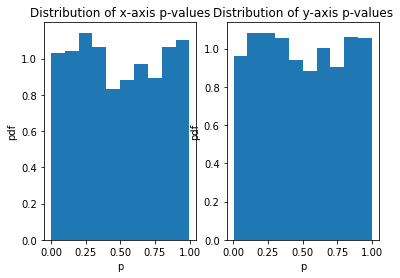

#### Dispersal Histograms:

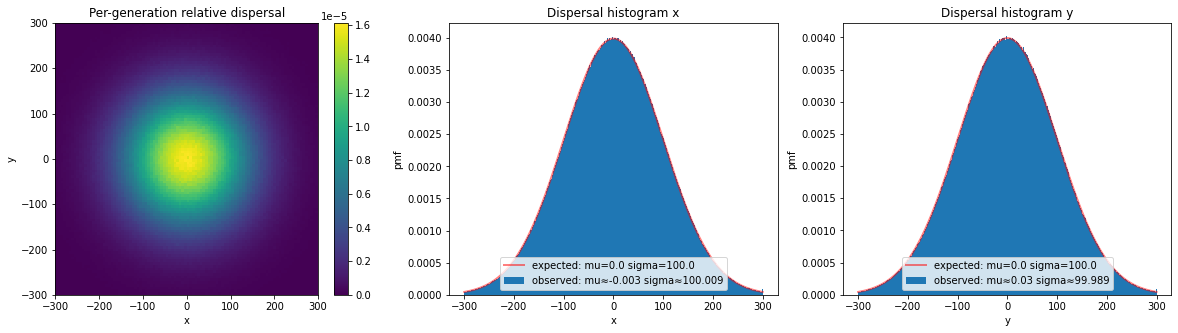

#### Parameters:
* seeds: [ 8758239503296706996  5293033032601481724  3266750749771844759
   171637975028977419  7988265503669841775  2992875929152136642
 14074380684172882558   385460814386966055 15476569943553368832
 14243659922310216284 14579568963662469353 11363263667381208583
 12216504701357270315 14635749152917038681 12331846995949730817
  4783622037342927573  5775532862637973917 12566251734847693308
 13182209159641714838  8330859812104055346  8127815270230777931
 10276379812002935647 16747140886835632550  2200351655091541435
  5882885401496658242 14746043250461196760 17747721769819887479
  5933726011842113758  8635681757967004468  5946081282905960611
 15517245318102899818 16734708548555350645  6008795543454996622
  6238018284112072615 15487344381552303488  1442792516185830007
  5100520264788871251 16576155582510807902 12947244631924334731
  3110006364613669202   265589385415277615  2098874833754510823
  5996323946064369289 12662744886042951160 16192221569302986253
  6297700267893779294    85477522731775333 14601100538790983070
  6669695238364346374 12680330377207786167  5285771065575441477
  9168903498071799335 12051237887920592864  6531780689713825709
  8960617562983714045   201707063833040082 10046252559034282987
 13291282639387451127 12792147981868804246 17556086836220294222
   346429329538060278 14250084909251351956 11586341575686860010
  7713083742775256773 15704089160297101285 15546582087393332998
 16890517165362534803 10710098494194415414 14524305136542793596
 14261791838333425866 17784157534761344237  4562410302841459109
 13981243160554569039  3431485804986626377 10784560950035689356
 15955238890339569037 17434282217279295450 10148821145308910220
 16559533322306114369  9425849025183491835  8893957626714430840
  5851730796600812934   772253146618208099  6025874520117624215
 11600174668954905202  7258295139490668592 12239329062745996581
  8605820602292480855 14020496550242745183  1212316283178189005
  7917771772602275212 11965026992230888292   736321589371207863
   247266936505066773  9905230015084423708 15331377203693620130
   665039746362265694 16498918587937997678  8799394634976789927
   865292980849512277 14739668048031159820 11623638918144555033
  8909265948039979139  8387390155644839598  1547613914484906964
 15137965851925814237 12831762110446227464  2988467615520862754
  5212784337128587694  1818321763325408778  8379998013740370482
  5488278313646966948 13604418255552066431   729920415064635614
 13822257070219130755  2244589455999051809  9511993262278750138
 10980008719495290060  4376459858485105757 14979838417323195905
   610303039967722377 12371713288542798246  7520524556726206581
  9736844386288650988  1797005019569699554 17804583769886378261
  7839742212662456581 17923274536174641041 11900490438430108990
  1737167208017479597 15581406876730903734 16672579849410093638
  1073534720229301792 11554403727081462218 15804808311575978732
  2390318537698568606  2295335250540397833 17918150981520929604
 14692963736353697008 16933232402629134523  5520934637585788675
 13616035168425281492 16874199426532825340 14445453869827604786
  5959524719611953876 16468566104503954635  6366296700611342265
  3801149533035440168  7919690899747078016  4271387069332072045
 10272689742557817552  4439332248706353110 15181504354725280516
 10122524736236007881  9589858287600303432  6224919922433761918
  8824026760414933171 16414123480981614138 13940369119097426753
  9752897595025344860  3383855659927880856 18063416858181417960
  2396144264916929016   182255037812553184 12115982108932685742
  4287582012120630774 14633351212386325336 15649483106851454520
 15650251107026758520 15718631910422093798  1820792672437911440
  3796650889223923650  3144082108851831048  4427992624983268233
  1172477697416480087 14902917952596111000 16729490082968979775
  6485489511879348807 11085074838694927142 11049406573765838603
  5359765564890488670  4470292915955053778  7209810240077787813
  3966554363652954379  9271211074019699295  2040195405711586901
   995907986999331868 14675401412355719407  7712772486453926569
 10694932908927423847 17262048326715315572 17485598609393136744
  1697216748892882357  1730044608027229121 11702790573606803866
  4586576527597565234  8254122602963547719   384809036447611697
 16646519407983658579 10694183003431254509  8716079476555502184
  4351635869353974143 11565871082061476984  3915539504018858516
 12696126816110924653 10511643591768432159  9698117297612586041
 16564087692857185961 11087042608975402643 11318290389352344846
  2848304681689628845 17305787074897888534 10843481801040515342
   483109093325167273 11844483011625454428 16331161162173317135
 14051038939434666047  5676240909972583495  5483846226978351540
 14218043717277956329  5592933766448242391 13578991611659437654
  2633163777989357745 10955738534197299750 11530119733885160842
 15517671030384942570 13445042561338360207  9303029079496601116
 11261012761017045687 17959187350950993671  6750279198322393437
  7967406450289596577  3057937304960979815  8618836364570421722
  7316822630592638433 12102483424898254153 14200506281052756663
  1532052746502345725 13088902740887101216  1613017686344685970
  7540672048174109752  2472674930318025344  2816421836046789201
  2921093121427615337 15069841989069158891 15877008332064721900
 10541936405346312738 11434979680452494282  8199047146514374896
 14601873800683669578  4043087938118418431 11291825007597251111
 10531282634882737348  9781727970849164154 14006716852467653075
 13992258677984729852  8799974133512056750 11808432845309632660
 13609034014871397771  1993392613804466410 11849602391320171928
  2487170253799558560 17198934712762598949   240011014666575206
  7390089915014331096  8284887943940686731  1282895466154099355
  3638850031778880493 18088005862443146361  4117037313912422138
 10264043681584825153 17654022155315809733 18117511592078942877
  2189230664922032840 10057480857827585522 13449744228839908258
 12492091017323857557     4704562652174073 14429072602357939604
  8357326554598259953  4326382779507313832  9912833945309545843
 15089236475332236164 17624114689749853502 10322119869896312025
 14030215155037854545   952844711089012596 17849523972609288781
 16347430500107830705 17885112959343798647  3383125280297046523
 17994090591771854098  8956368920586499751 11064302905968267318
 15172033519323102368 16504629767500020276  6566255337390184148
  1815353352967236992  2837828075588465622  3730519963502224387
 12936388470932933961   240555368892128575   210542776466579535
 14978858663593690868  6026977747751521168 12560529935119972041
 13198394892676955357   974864647047882092  5078755459040676105
  9345956119717120712 10782734510995178566 15141485450784237908
  5306883002274722371  4037867258535294969  7258370189861486220
  6494381894237568288  6301406328519759896   458414831168945103
 14970891721724868467  7241534967853625280  3159388423582739041
  9137955554163115943  9825697128021028875 16654304740995424634
 14774076307132333928  3293565642260107923  4184541763448868208
  6443045445645417539  3436225839257678072  5475516256697573812
 17911188112214806109 13930206628033485841  4322527204145134100
 18401059538614522565  8865653029668750951 15026884965337101687
  5265161869287502871  6919952285435641457 18116848857176714105
 16847167038356571315 10330005414711928048  5972411628804146531
 12290427041772327987 12544690680387423198  7314517239903123505
 12759262383949548809  2661235307082946149  1999285877347095723
 16837468785294879913 10851660709320343925  1458296288399999766
 16548127664200026984 16209493230687690805  1031802828541045238
  8770560932367291790 10712510790615596528 17887345548590856353
 16439154424313773234  4457240467941348086  6757461021443475418
  9758186802052776393 14799440531849894936   264353855415040910
 12190067073883674607 15695570066611175597 12507797287359513651
 11650606294250787226 14347126664142253802  3517077167203609164
  3565239821152380600   193250508333602971 15148186960423444965
  8793432757079029301 15673116898220866265 15209182458269784085
  8642644119075964027    12679093303990595 17901484709786673132
    31066841940088049  3495039244576006568 17630011865941626337
 15612941290294634474  5036968396896521082  5219753656017328883
 18246409182750474717  8822884426127809348  7580317398454934588
 17774013136071596635  5482558941415261669  4795591271756426911
 16070501974552985041 16110595591160343312   509638951352007089
 17914806387633000129  1735708841741550195  7439280347797637332
  8632569756577742414  4766544485247939013   261995390166443948
  7532615386332536190  9941649428660095339  9623756502112629002
  8622460461670873923 13694350977297853923 11051646345924200895
 12064696523510747989  7360988656596082826 12130265748156294257
  7196552348176667368 10984559427977810086  6588071862368967931
 11293216230006726689  9444730504826527274  9147157589159991004
  5323101523556162120 18139363353899873968 10951356564773766722
  3640681331078703673 16486993736084278906 11658278784542340970
  6672992218879248890 12998862327641374212  3475187318395114124
  7236281765931122253   811596967493367145 13517839314937424714
 10406816296403525036  4971908226311887210 13507882402245199845
  9430757832828730873  9995279220046552901 17969489886993968186
 14021143831836036632  2795929072174962144 13627915369832581565
 12221583034080346660 17653245209714894134  5641380936968155300
  3567778648614519518 17117736748660425882  2654602773225122802
  9427757067641256847  9065932328623309189 17531161450476196400
  7622798308189636665  7377415186381919114  2770059465885192045
 15605816230523851786  3065928544025008017 14332951967733752470
 17090210852167726272  2835529209504771858  4035570288768913709
  1259223193048891824  1270317072631890993 17615039661790365938
  9147945110874658483  3584935347023324805 14661020658011020193
 15196143980030775808 17422754937411783124 11939330004863561132
 16819593084289679623 15383260609136578032 11586314160562092063
 10181502609500185008  8681010819371251528  1843979698009119660
  3377130071924006891 16790382373743176760 14200887990238679289
  2771242157414231875 16897616291853815895 10915791654063071718
  1094177317168685495 17255796818059005226 17927656520131990900
  7411856613644539631 15953089385703919386  2085613009527823096
  3149037972751072158  2781019096035548363 11789495082101081378
 11059132262582019668  4515952212869203942  4818708206500175631
  2656384521251998085  8242846044136302446  5745914332959244206
 11411439641424021307 16210843551706815779  7333376038178830790
 17781163175767967019  7770241610320843290 12564452842624841479
 17425677001133501320 12834515601112105718  5348444131009601653
 13895764275561307056  7332846039134538226 14437621316195601436
 15877784347407248025  7982757364765004853  9581034820233869416
  7780117864268068820 18222902081725674128 15302885408134367476
 10742537802646740477 14171515582435287741  7380151177824424525
 17635309021553166119  7265050317612456824 14267340706829429391
  7738615140185730852 12151018595315261088 13237934581820765797
  2892638800579435406 13594663627408556552  7866691938584104040
 16703373491934798216  1218011545678521687  3534783934843875263
 16046909248108569414 15225503997978366925 17156417269279530061
  4234029779337740200  5931122562683362993  4542449592545725391
  3845840418834926832 16831916655377875531 12139005048354897507
 14622258904322256025  4388649075655165074 15343197592198300425
 17715638198674960767  6662002310602235781  4955212751832047172
 16516422973155481425 12325211644397825752  3448736434046908414
 13804218517751965600 11870981810760540839  4173488621952437695
 13961814511219703156  4346910959412104187 16851567664053981174
  6238447189203681102 17978148688961461376  5026009925692509233
 10271094082474719687 16018837992033442082  6148343194026712016
  2339253367044044172 16476286791762293501  7426659879051848964
  8226757603145134383  4700692981001244390 11271921768641124486
  7966216708456281579  4305599080204941698  6372605767788053783
  4743476027054998959  4697386977753348972 15209153297540206793
 14416802740958848941  3775002137013960998 11375761869739596929
 10486027950432169078  3033428499883596307 15093428401074664230
  2848794059375234464  4409518600683045889 12175580556575879204
  2739139886731601904  6612543312155155016 13793999965587588521
  8322063067595923905 17602241952099613140  7786956599327914628
  4554846862517774002 15606948427287937233 15955807789538632138
 17054751127253591159 11926541205559815344  7184639423130267763
  3958390601686957275   967377841338476429 16596107393919764897
  5819344930295730782 18300826206785063693 16357658163527116764
 17779204399494501373 15864178054571254749 11542605778309759019
 10682608163232746659 14158136433459414285 18386576563107898043
 13781275679060486594 14080009674060372155 16295529934052388484
 14952360139214328451 10291489565685465283 18392365235277769013
  6687581188188751874  5128475268094380801  6375442524812502464
  6635450415332299586 18152765002655602515 10633604063201575050
    73387443277894900 18411581967745227368  1943048419745127233
 18017688299052901087  9308389112280458429  6141719715679346910
 11029901474937653606 10769534842317146051 16210287376684417828
 11693423082074990434  4748188761812797859  2072910887199339239
 16703472870515103726  4804363811667651219  5540271798185388493
 16225098721718967661 11705934968739883600  4699323214847928362
 11625368261869012520 16661310407633077699 10167587459372187694
 16792750622052610738  7415959172542399186   872831726910742344
 13816233350054307635  5948594780844206240  7877056967707241494
  5892735478002626879  3457333957648710134  7725725352739922489
  5782523086826609998 12367732786939815550  4778604738398172655
  8037749211774212115 10441573181149570501  3937065946225380615
  8917629517390138458 14608079559115214916  5955585337681340456
  2150126241128905421 14123584906075614473  2766140754605849414
 13329436504610385050  9849559336402377900  5328343086029177549
 16564680333824625808 17994980563601161526  4922020630992769809
  4122683818574336095  9462509840991712265 10953867608223721309
  9206886801749677035  8707503075329825720  6552051621209408835
 14382327574859986155  1038155064451243795  4868044460902054535
 14386505902227825031  5920708172044019415 14051145108015197564
 16595680656390753685  3757319167832694247  3869994149034955632
 10408906458771496494 17871886254776167159 10116678291778982629
  4848124915494941181 11531010729213666672  2776505254037723439
 13860490373874071234 10518097363886409173  2016252056914115590
  6159910516757865727 14088819072342861297  6918135738394248642
   308674164737448057 17355964913836009126  6041574554699825335
 11183524854389572622     8122164745586655  7934090898287839369
  2796895197040567347  8789354144705041980 10027951497153446044
   802831562207789441 12159776979423765245 11204828490907656028
  1371940593825884749  8205157801761086088  2880385787777158248
  5128499998398240444  2279790723762598736  6391192121446094278
   192276634827507318 17995036302524380916 11432381742510038919
  8156950151543022287 11740601617150578383 13165811871230987210
 15851324346673907405  5638072144546949658 14556876430931394272
  3851736119225046300 12923798880991799451 13222596485455302587
  5648977795571481429  2328052697215985099  9785217736924709816
  7604136600490929214  5257419520663504463  8689689385132849608
  4451266971837188189  9480111229497760420  1404378295959744439
  8527077973204735828  1073092556364474292 15634452330597391264
 12011879978633648323  9253691676026206577  8033415244932381255
  6919182542624640722  3412462312782942062 18077410545976603113
 10226399664480065957  5172108118801076919 12959016267797604158
  1419846547347452411 11444550525347432411  8058607778980761447
 18104826444841840439 11869614792216344959  1418768807068699996
  5413303280036635942 11277872605250918566  7685434377277498791
  3386453917431962902 12527884229666492552  4562681027230732089
  4722278585903903851 17298684058167782452 15264121668712789549
 10420982015863188620  4381831679996718901  1092948000717667115
 13208189422735352923 12490876089642539163  5151917391528733393
  1868578679133204268  2469720996583488551 11255118268704942898
  7448659804402925800 13024336336724432416  5737749727927529389
 10349615631033346126  9766127116545666977  7898218599621048035
  7771468262193837520 16519993974993022185 10704253364488533350
  6938016490992583725 15710365703656205039  1166638139017020563
 16577819671473301690  5023043386416846203  9200509194969465482
  5816527665974410384 16542001903100337533 13540599763992263093
  1858545922999299065  6249319209968072918  4927679529564830280
 13665661415260321901  9555632395736117414   599062660311511039
 10676961186060452479  6457477008399734219 15550003343157509953
  4254293665645595928  6794638125203490509  8271310727642514831
  3011334505163040235 11252261626649125522 10567385618988189909
 16170534278429759904  1712240335992510471   455566085098027501
  7142419637092795027 14098008541319134130 12346433101151477263
 17164702888638555245  9300579841620228078 15941648596045741557
  5334276433893004435 13414862975379541636  8382469599000316507
 17178089406096734169  8840388282737205345   856043178064679926
 17028361219009688121  1662744344784566650   803570628319486703
   995686941304553521  7626488475502855455  4049933634183035413
 17702366981927181369  7815957048489276522 17281757476655211811
   391571467069165401  4585822361120831492   738429291798203926
   370606325100852539  1834994830855059917 14212068641829275720
 13085020122623603325  5900326452426511296  3489114948114896611
 18342025343769480369  7899896456210114939 12618390022868774834
  7098213958919151378  8863043793629057822 15469695352833555507
 10647108580077804735 15271433684449401523  2493240645206562339
   771904921051510352 13756248985811423296 18085982912870991414
  8996275605879669372 11708237761170728939  7587182662708981626
 11375631894405146185  8403632806514950248  5918534018867402979
  8650967033361381418 15895267690101126021   895860329478364704
 17047249923333625552  5120147151843448911 15224649503852157198
 15735695494917074778  7354593280500238206 10066496281126985346
 17012684175204654090  8538581292016229840 15697782898280557565
 16150651238033708155  7347733433282138315 17386897116478179432
  8203441857331424835  4553745899249732899  3837856434349207599
  9017873994019242214  1844248259775338994 11843816669374142194
  4324962916701913705  9218841255743939961  7924311288194828148
  4652596349077106504  9742027689567476725  1938900645125833171
  8352491096065115106  4932212363635213226 15882786562491400204
  4098911642091216783   980818122057208068  7406795709711387819
  8662760797708229860 10310320191197108162 17291117513473265562
  7720631509899861551 17550607659974327593 16488129675378470323
 10637753447758990953  9099196542833236389  6023132205582553162
 16323214788176563299  7472734701054080231  9505800568477415809
  9526831593229321670  1990788790530363060   782015363346346103
  9043145232234211157  1984386887017905963  8708305549271533902
 12494410117353555811  3436321936778217583 11965714114161105153
 12973764488284681299 13118659915267060584  9458108495240310495
  2119975629533139970  1365744633031411651 17796138990901316027
  6786087693087693346 14967939141234180931 15807749139353679794
 18246765721826985380 11048867914882848576  2725220663374098776
  4177134442352533401  2127235754470542234  3888606304004061601
  1353146370909138261   662292693775348196  2512886812092828360
  2802176895554675380  5882857672556595209  9562410047152094945
   293939850350303495   792941707143962251 16973108242783806933
   551047861708565984 15964782536437491295 16873476208686884084
  6873759542097827267 11387558557734890023 12683075300197626104
  9803860541992608889  9472349254338307803 17868158895503946491
 18374532887536688997 14529637787019077371  1564494000438353554
 17329870476597529252  8686564979380834755  3168414055326765983
  7785359309523018569  7736744508747467524 14011283843273267683
 12511786571840576433  6334674577286711474  5381418441222284307
 13888759088780630930  3581111442619297319  7215098903068891444
 11177742127761673307 16774607773684419929  6812849455061688544
  2747462236681794085  2334795437604464127 10743179071609179938
  6307432833671246984  8673214473813816306  9042875854938816805
  5419678409293887163 18385777073109332739  2782586218259696619
  4399405063691201953 11658138753488044966  1894723878731717645
 13192944099901428264 12006684033730222601  8879441163656949929
  8015952083540526271  1852300944058756434 15025446375490319253
  9738950655551597930  4393749475703911568  4038645664861679143
  6419670662090486156 11885204230716932396 16326354609046010372
 10791187983557011127  5864747573467860469 10933231068251782058
  2507821968017942597   178267719444714796 10423949884353126921
 18402718158472315381  4139898455429692295  8300822163335710547
 14238008798091475105  3317067036546681135  2753976799589138554
 11211310048203031938 13435048677034480428  7544324836243349592
 17150698915740120391  2149759777039215881 13537670369772785958
   738367415099512035  2891944798938786620  9545237036881266668
   882234658790991975  8623056572977497308  3080672285486592561
 10489707986394040383 12922703420622340343 15902633722998853889
 15865135683457603663]

#### Configuration:
```rust
(speciation:0.01,seed:15865135683457603663,sample:0.1,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:orange'>*Independent*</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.05139986832378282
* x-axis statistic: 2104.2758729101106

* y-axis p-value: 0.8732888476620341
* y-axis statistic: 1927.983077053369

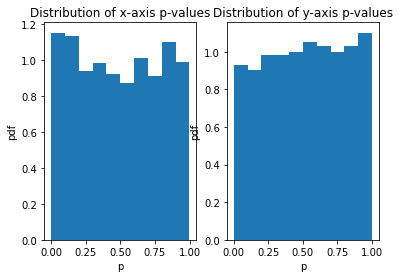

#### Dispersal Histograms:

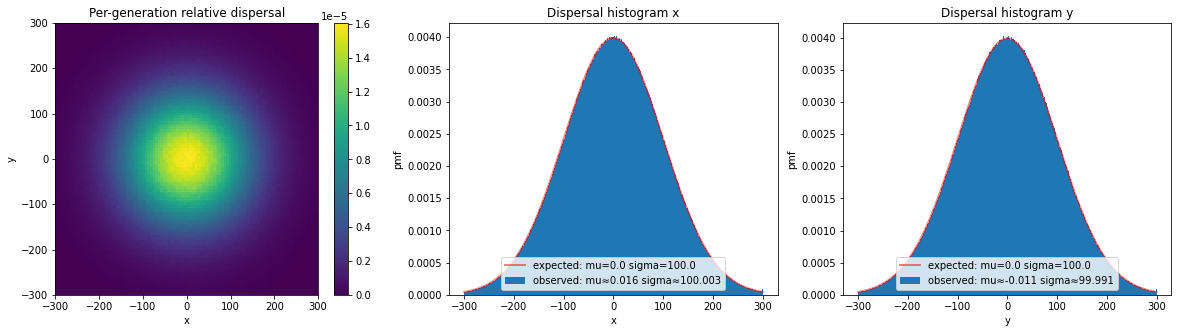

#### Parameters:
* seeds: [10874937976275577915 10822677642802868895  1489825466906717653
  2865050786152362474  1455702999284765861 16081113508976342368
 16592124678788357195  3776280372136263345 14949740291254995567
  5916574014861848612   564690263962685400  9805986825813474602
 17784694970802468646  2348552035800904077 10215930329357376011
  2434523949745557635 10802757670348941089 15756848827335789281
 13939449256974421480 14317089565714582129   201555323626583238
 11468469823673692180 14617440805903795571 13882630340734953286
 12872770540486844188 13960050289350154595  3457622543639459893
   671367120539579269 12607293815113298120  9596019676217577763
  1069125676127004473 14133573737074475611  1475886222962537833
  6291918260093844709  2578723078988939310   493918424153808204
  6471893882817251442   617055933905382218 12592819358942621815
   680829404212112006 13887262226715373073  2879619025939252700
 15916868800232815332  2303590034170231123  5743012417178525460
 11196241726101055085  7202094990709672445 12636981807848087645
  6832192515569710763  1768903150942148162 15733955492422498530
 16607744953428464459  7230150938043286305  6559086212315012705
   331900485318152030 10557644361692265697  9517786529103150362
 16266086032600286027 10082044461257281758 12077087287663244040
 13540282688843679222 10286269631224076875 10845180579007369633
 15200718908555285799 13854132775032223651 16740562957015135123
  7699495711906591400 16600233285087248967   923271973493377475
  1618993440191468265 17925166543060219485  6319527103143720943
 12705476571729719088  8574780140814790885   368327564222606635
  6576427088101847188 15255535087082877777  9117257248703545706
  5185154573562517721  7803206285770002817   351957439385063840
   335730826348459818 14641290499964643522  1103732003706320681
  1467554321297238683 17221093354985703639  5671772315962544588
 11624028039623011973 11861534750275748052 12057862635261384349
 15516776502433326403  7119179009871971498 11793538040028798730
 11482289007459653033  9087775855659432860 11474749263660502663
 10518582447877960760 17863360525510572454 16267910795939244703
  6456731678021937286 15976912398611398825  7517695777008510193
 14007160397750567547 17133103237584780023 12951039647119191138
  6737791247177810333  3244358275919252778  1315902359323562678
  4188759285139679269  8588399328084501429 12747843470150756313
 17803755599937010022  9556944765637149301 11114281667881129860
  2645822793145419619  7208696268322143639  3107032040423043211
  8268583464468339102 12124680497178970930  9168339426235208172
 13624503045926865915 12759113683712305179 13605253894470330842
 10239118556370197258  3104073422140213508   829066182592551555
 16295084549685150758 16676167597781980323  9704787744713224954
  4799580065144317972 14356682007503784543  7029108856539556841
  5080611191964704762  8758442135747758792  6275458320957855795
  7087285969899553941  6286516958263537809  5246799209529232777
 12240225491826811812  7667575720142855635  8793142034159802139
 13715704731911536665 16625428251712672784 14405393639340426251
  8687577474649502186  8075833647758454846  2000838075292886688
   933325057121242084 11951522223125966981  7748104546874497816
 13804653745213180556 11299750979259080974  6045138895155629403
  8945890152335584971 17327667489357719940 16504405679622866141
  7828499521295546058 13210563988117436942  4442683947501580078
 12335019119808895440  7747315306404562048  2794089641861358578
  4228385712474644683  3386058071402812360  1574909596267860122
  3904596951241681427 18090839110704321576 10999542602245571612
 17959410143748954398  7848915109170777531  6001440250171249982
 12191581840106230772  3902008130083878206  9991975376419251429
  9811367510008766265  4778469067230599772  1027444931865398883
  4984497923096217040  2818644654271512888   309738821697269637
 11005101904840582442  6103497063289704581  3651684284208932582
  5740581465029473678  8304155843286504835  6999897755885096915
 17705669593506492575  8141342353200313831  1731297593762304899
  3678791668730194936 17887855535691913807  6415829168359646630
 16867643905485189130 11081136886493011554  8580289459488714864
  3025853277735533190  1849370268759066529  3010529205577087441
 16531173475321400561  9357412264532134412  7140174884829336500
  3016270043134968112  8764021550100797347 12379667164158811543
  9885491910915399385 12247255996793921911  4959428719036461795
 17648527034323710303  2513191520827226613 12677156478916373974
 15060644130095374186 12017933350828469480   423323890462197315
 10543827696113634338 11364504516629881294 15440095847176996694
  6097712910967622243  1514046784998727917  4015585092512265338
  6620238824279392736  4014094735358254902 11012698070140659604
 16539147241407133763 14947141111333543650 15246457825027991081
  4281877863651298343 16464129461088781658  3857660984543429448
  9115750320905383171 15469435814764478352  4924999534570205552
 15604855983653049662  6588697204384046638  5432297269276773533
 15725835017803496181 10843224216571238619  2171127296789811729
  5280914487341734832  2007517081314540515 15769069844472543362
 10102254918871725609 18154534389854271083 15303774653944740723
 16884373789287587480  1380358366682818807 12913143084589619357
 10281545911149046717 12699789382354815483 16575110431858016862
  2369779381871431167 16053689473461052180 11034865181585703916
  3017982808662900819  7131044936113009272  9062471419220203811
 17511595559396989405  3574191242069274817  9746098908274954570
 17464525924600609176   413612045080085453  6699479725433272787
 15272726642973033925 11442810185441075868 11645870800381113634
 17933074957927154948 17793332155671127663 14858157133688653160
 10910037709544146082  3532546042472712368   222482279090477433
   534136908541618888 14437654117889837592  7354583741544609974
  2660904189548037304  2911932247434160587 14251457975531848447
 14520975351414752888   759525051392753062   108774521762430806
  7266137398847639973  6002378596658596544  4309484265843671499
  3938609381036405882 15466050149556616885 18011644855943484890
 16308988107697353036  6086427081705888044 13763838053671574722
 16192288383459762095  2122427092243215917  9902129081659283290
 10595126212496892016 17054231165131204922 16274817308890689713
  5928143536835118804 18273085805123750456 14144574189266385946
   527974809548712575 15389485616456495991 10818389708045110928
 11416782579322897942  8275447330265635495 17787942227043242303
 10770713327739167105 12897361086154364410 18015247946423675355
   933538262884474040 10247231443249691863 16765222871676722324
  4049182455039098331 11657610473975594881  7900636681015582740
 16671194193714213525 11849438674937694686 14680896556020062885
  2156405435912987781 15702068316278403660 17783707143505262970
  3213197466790019898  2460852173545705793 10723821920804729207
  7795119684907291480 12643347072490916709   457505354234871606
  4457325162399978836 17274456947245939653 14909521853730226993
  3094244893759908595  8810432534806720373 11034667657031078518
  3748258114320747505 17232983761947024110  2746909721301844837
 16973636196387337073  8756433613684036745   608640464603214679
 13991460465885930272  2533984055397145954  9140660262253705058
  2588443101866813560 10924776736826058886 15981373025326601050
  4081978610788826370 12262763277184537440 11117778947302386407
 11767918179761879113  7983257473371818173 12026347794721561958
  1045294343313313419 16067140324275865759  5688438890132997101
  5668456103157552917  9565763267039097266 10326723449752996518
 16933847832597345973 15532637772405043894  6551480547643303545
  2657744978822890528  1354314616092763204 15875639097375899291
  9631691908899493511 12775181440451821403  3488682199347167980
 11940673245572907865  5223786366734505136 13836256199525447337
  5768665681179699289  1131111627327417784  3351509152013319256
  8413764931079913740  9666786987580081028 15210360392816296158
  3770863333940955667 11897015725965907727 14380413802033981796
  1038580708035314987  4095502376997869352   168251200865692387
  9387276061095106680  4384566636643918673  5340602026444447468
   366063452678645325  6202198698251482641 13499744924510033475
 16936059551041592324   357211148874999182  1277590913627719320
  5710340100586749500  8457468877414522365  7152583686412826949
  8530350689316665540  7289316488249231244 15150893770376148959
 11044652482544114567  9949057774666018380  7036182400763072208
  5813967352379109841     2155603224654987  7909065312722339918
 13940238272925146593 16598877265983946341  8902939229237262879
  6594741003210011004  3202592198856146750  3685680753760013714
  5714047463118748934 12236562883194905787  6445129045788938174
  1002495783284342550  5242873630656884313 12092610328189359992
 18309675149278908425  7005055412136949110   194505245092942188
  5532667965927963221  4832101403893798847 17359700770918094987
 13338737466313924653  9825448910583588054 15977279989611899682
   300185090219738331  3964860638463035706 12617361911959552018
  3517883880070763308  7629106246464218812 14857119759767430707
 12290492409596910606  8548971523947390924 16954593693489176825
 12022133817188926829 11666234703754874376 12097816418988882065
  4120830702456985306   751655992266987048  8300959316596830955
  9535538041090860773 11520088888730879644 17874588647631369271
  2939001118245544370 16650674593912686897 14226206231098176043
 12114359642879618716   944256642466013346 16361861980840408250
  6376860311080877975 15904607489481849107 17333267997490854360
  6825067117114959847  8580877671520688143 13629819968941425108
  2142693344500930055  6945758983701849256  5557002780111367236
  9153048129569591233  6335622133139247863  2404755349817417634
  4487596207027848285   901732288737060701  3050126267233380748
 17654882273481940169 15186499885147715579 12630410557301887709
 13768350569667389444  2253246350666809176  4491748893114850155
  5116545623633955756   885190789208699261  2276740801435160022
  8108469182266184762  3907420503545109743  7976267758428312770
  2977441457010288462 13314721350687734335  4657607868731835443
 11326401815829061076 16964294425435174883 10482007450229715854
  2583860864069701282 12907341319267423632  3176328532073236375
  3576536148582306630  1677457259095876869 11924826273471958870
 10731526316144338879 14970845792094080975  6434540635235267275
   862393293952719112 17259681761922625659  5499211621521060276
  8424298437500178324 18411329142013707407  9178208886355865043
 18001682658264779669  8947703295070795518  8651965066771466243
 17184498675935732979  1085851211784943393 16494411489666718377
 16571727881282555979 13019712270823259063 17583592044432692553
  3005393324165719071 11243679924413646816 15895324034734884860
 15797406825177247270 13170744701577113654  5437711024242497922
  7752138341198322085  2333056776229306463 17517214611393185024
  1696116601215208453 15947781760878419607  6085685011930554610
 17105921078313833066  2805722410519848788  4497058370278836326
 18367244305198451315 11765913795670692459  6804740333545765560
  5777163836232727331  4856696926504745096  6068475814263220545
  3331895363370155628  7395973154981423644  3171784078949817723
 16466528464794696916  5436058414733801832 12015952100466251074
  4297138558545864121  6636237751846120887  1510302586035091415
 14089592174064602094   961983508523461392 10132865087593426069
  6840270631352027537  1002893167984164898 17226986570084272663
 11588199994870381649 17156191606800908010  4207793217764124416
  7077455182149119328 14878866438197943575 16793070350960015690
 15117049206010721844  4955223180791568519 12561936663493211510
 14955750465074610060 10520405365298613000 14362921742046287968
 16199643823599680824 16943972034465530265 11872785621369977384
 17767109114871410979  1722767017067313950 10259190535897698922
  8301024967987013669 14207202847578990598 17989601743171182384
  8198361211945136086 12064511052034502294 15251427372737470359
 15095282501519192414  3833312627268215553  9146956632700341323
   405852804207827403  9604836655418399040  8129306291463213279
 13725007931140742457 15729512607059924509 15150932697061890626
 15002344452819859081 13759408178379768638 17104031288128515234
   284142190749889287  6376577145672280284  5238037580940072610
 15203690283417313211 10452008089369334596 15743603330868396989
 18250711840120876745   488919397037132297  3400991695339540142
  6520144509480605047  3820152285444730022  6353146986692921200
 12750844392156810161 13502022905851042474 13302328763456022145
  3730994814416041505  4776136328213617788  3900213594349551685
 15400520769355110716  7952145427482270941 14373997116429079928
  7821555504391981110   268008381844487322   753944352282596101
  1897284606499788747 12962671815049254461  5732595975245175393
    98264412778016623 12283781850464504207 16349203540621972630
 17509587838667844305 17872723249239932354 14529096560201504238
  7050272628590609954  7861546531493129084  9610776276618105091
  4705068863102150782  8376175308125749671  7522148469600625532
  4026294684103075053 15219144265295008592   116369843534014668
 11975086777381992400 15015812316279788391  8756163272147028978
  8830059126870708063  3266031347598347293  8688485407028171310
 13832700034638444447 17182479807866864588 16187979500239108841
 15198628969885721008 14060135216931701311 16965585694838033602
  4996545771350513920 11726409271353819079  2828459503745835541
  8428180760988590133 14671825190873541619 15489730476777064210
  4131833556168827744  4337342533217388072  2576944813110764037
  6842380183254507387  6818590210043087025 15692474593948285104
 11443173548951721991 12735618948364091917  2910393584187737366
  9405066618399992745  5637719963822263199  1076605668392395465
 17156010677245002307  5653016169714699278  9745179500122485505
 15178603753284167337 15577933553333835417 15370962433479276994
  5538893497788853821  2438641140246587202  1152142917213921946
  7476158925676642475 16695904273574747217  6903461790636234872
  1563586005886302931  3386025776962864150 12766495924355435714
  5351239549109104197  3187309616321454390 10789822018788409171
   701830949278264732  7853713469058003422 17418875377141540858
  2367651408123006930 15232481217162513531 16630624161918595797
  7176010170401227648  3550119367373034665 12652134905893659390
 13071006798806656661 12992226675221953935 18050733385543831356
 13590872736156364102 12126844561352278991  6753903495055265917
  6896779234297307712 15394339607557855297  5760325648158644389
  5800859554137186536  7700499091061553180  7287471319048778935
  5534858115812156136  3621836067738064483  7529653167478234401
 15726208308315901442  8360466330397216702  6995491857963562397
  2612679409307148565  6583976523319081894 18190397082073463154
  7146690594153492493  2417893768079356350 11217086667924343675
  3292374274366854558 14877915779811722129 11345843629761036595
  6441032059644243679  2878005613335810089  9456144043240488385
  1533228391963559078 10941035051129924091  7420127458011427393
 17239665126671829857 15995025596256786271 13115436338519851610
  3057372770941149291  5415611471065036137    13752856904113992
  9558767740065775511 18302111180221476165 15949223604074471632
 18400633727876035076 13654966351894824267 13108762299412792337
  7071785964387069719   289939002843744399   173677833601876051
  8778833479250051033  3473752066059492130 16994191054478388276
  7762552720080344572  6070094007656117112  1047896893620351241
 15100864259450800923  4279362421893367116  8459049515642254920
 17274152064456196623  8724522450306638374  4399963478148201314
 17470022324652566620 16099756598647357552  3279620910077940779
  3981307990189225547 14556425452772789975  3434105297030439811
  2384382849301930691 11158387562547326161  3967358829231599135
 17918741486963443578  8843891993172881034  4062210726508468584
 15175841259518729451  3731982428669997410 11328402999459350659
  5971078583632958597 16471613906259482932  2264665322600136437
 11858716368874414079 17190119892780575726 15420878063887431580
 13734981985980384317 16035698279810839425 11834426277150140540
 16053810905779874043  1293833307899598084  5913995033668952490
  2398153251778509784  9096319438320322271  8107976475742878017
  7815790130776707077 16764342072061981824 11873170378103997787
   759605327323337140 11477352152592370999   882351445756702834
  5548612798116440747  2798935495402347374 10872389653054589617
 13279156546851986123  2518625089049619388 12691452355582949200
 15004389091049479468 10335760727375402769  9840913211643107138
  4188337462616583992  5889780126409344803 11156650601623696156
  5770575323745631144  3300707732275941925 10891813203269913237
  9846596716169536639  9774238733051463063  4073082393394041315
 14328677064224515663 16512579314144065784  6055642891132847013
  5329464930989588145 15090906598566008288  3242614485434125334
  5773376485764709591 14194477104146354000  7374341231355464270
 11709507460814431054  9958530621778511327  3092778111309782290
  1736325389843638623 17974006272709369673 10983796072000881760
 16132159049417490147  7518961352315350628  3800783152299120635
  8315752143829063688  5246245923240719085  5953630681086837642
  3273378247054115884  4246276761246561017 15438229773429113459
  2736650168709782694 10634101081263906821  5053777533538807251
  2268044407856405698   897842237829320392  6566466701316625362
 14732272374070456895  7848734478189112790  6278569692133906039
 15878589203393334334  5020653930011106200 10255020345311898197
  8462378493888627347   547574973854571608  2521509724112209738
  3290594850959116760  7888439472966416689 17033078262508219479
  5660619685992364206  7062314141425647743 14152574257802962880
 12572009831920312075 12391085605561149562  5633259708630433726
 16801226938125362712 14473492593175748722  3740173116857979628
 14719854959063711879  7493602279001894153 15975573101470916397
 12762756201239148505  3976097249191865462  5914028420145435258
 18366041949320049837 11368687314656974529 11165532807146883001
 17985569110723400516 16511283007915810340  2386601206036865062
  2698323150485932677  5206831294832221970  4422935938100407382
  1838955632185065328 17057768297687194642  3527419231084174942
 10760701352989689354  2963346062058202623 12734012504008622965
 16092416042699473394    22770277740708849 12731381696350315986
 12123658306167657506  8988707833471642095 14186521883286777513
 12711595740888668887   483445427419617137 12624864558375707540
  8445078898146800193  3393654369428830504  3508273342072177524
  4618178690041518244  6085830161936583499  4326787740141686211
  1999267498648278156 11905610682270631587  5731411335341931535
  2372552145251339390 14152527002501373666  1866936708507633336
  7181699408990748656 12719730465196573377 11511559317197552194
  2117155581389828727 15272952761207783542  4978047220200586947
  2794290199903227875  5224337106660482844 18209820977986924495
 12550229267522797194  9714845677478411867  3985370931708814059
  9427957906162388139  2001636916938329578 17034045871043248154
  7145079555830581254  5095980238994751621  2796698357278525097
  2410284105955768551  1487613899350825355 16621377097931738136
 17710737827136575768  5989404091030162669 10482412487248214587
  3335533707086843776 15543145008136982043 14992999058706198940
 16252620518213479487  1358969420724802900  6075781452802898933
 15036489668489052611  6611897176743419413 10639010640869211919
  3495232500848068919  6571295801606863382 11255522624177970382
  1331280283487388926  7853794148897311191 12684912880212117975
 17169201817293556482  9951307563899302520   327015450773340765
  6161295569952041608  8294857061134981654  2508146214253734996
 11260090010000162155  8600954333112519582 10681934052008955187
 16948944153789457327 16312284760031688884 14552278530225046463
 13638825923000647314 15868563024191648201   847555310430992381
 11544336898151390144  1701284239064054705  4456053012909297244
  3830374840135235908 17435604871465481651 13836618341260250545
  2713130822540963271 10725912181622607617  9070811952736230451
  5323180787720363458  4956323923343924100 11970157415907560990
  2919702827166022963 14037051933106920401  5386537972433101300
 10773891850588521617  7509642030454310023  3915197592771847395
   490858426161690516  5386354308118660425  2670484716399662612
  9043204109928037108 10253797148574575983 16719559451528724947
 12715455222566828449 13431331255706113102  3075799395704944677
  2651099028200881080 17414204049986874577   796953235391630327
  9384935011780198232  6157092191024396486  2032392837814972809
 11997101047902355498  9174578496331180697 11728348768186402693
 13857908022363701523 10582468086027697978 17697540674629062820
  8825024619530342073 16386215239786675385  9110590373429705435
  5059865639998069544   251028076766472840  6808502032377678431
 10009140914229278121  7842596299021237379 17052775584491145955
  1718273196034018574  4505439748050667222  5093724449964355108
 14046389839832825540 17266132440695003386 12540529239701361570
 14742917622038620085   535162388767334907 12355550297099750031
  8401311562115405768 15041334350328087440 15967928680475886740
 11458134563264071804  9843989104321170335  8182495392368550217
  4614487656474289054 10857863854271649695  5177201728324468434
  5776138185271362818]

#### Configuration:
```rust
(speciation:0.01,seed:5776138185271362818,sample:0.1,algorithm:Independent(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000) 
    
    test_normal_dispersal_kernel(
        algorithm, speciation=0.01, seeds=seeds, sample=0.1, radius=25, sigma=100.0
    )